In [3]:
## Imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [4]:
df = pd.read_csv('./data/compas_data_combined_matches.csv')
columns_to_drop = ['FirstName', 'LastName', 'DateOfBirth', 'id', 'v_decile_score', 'DecileScore_Risk of Failure to Appear','race', 'DecileScore_Risk of Recidivism', 'DecileScore_Risk of Violence', 'RawScore_Risk of Failure to Appear', 'RawScore_Risk of Recidivism', 'RawScore_Risk of Violence', '_merge', 'sex', 'c_charge_desc']
rf_dataset = df.drop(columns=columns_to_drop)


In [5]:
na_counts = rf_dataset.isna().sum()
na_columns = na_counts[na_counts > 0] 
nans = na_columns.to_dict()
columns_to_remove = []
for key in nans.keys():
    columns_to_remove.append(key)
rf_dataset = rf_dataset.drop(columns=columns_to_remove)
labels = rf_dataset.two_year_recid
compass_preds = rf_dataset.score_text
rf_dataset = rf_dataset.drop(columns=['two_year_recid', 'is_recid', 'score_text'])


In [ ]:
X_train, X_cal, y_train, y_cal = train_test_split(rf_dataset, labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, random_state=42)


5460
288
1437


In [51]:
best_params = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
clf=RF(**best_params, random_state=42)
clf.fit(X_train,y_train)
probs_cal = clf.predict_proba(X_cal)
nonconformity_scores = 1 - np.array([probs_cal[i, int(y_cal.tolist()[i])] for i in range(len(y_cal))])
print(nonconformity_scores)
for i in (0.6, 0.7, 0.8, 0.9, 0.95): 
    quantile = np.quantile(nonconformity_scores, i)
    probs_test = clf.predict_proba(X_test)
    test_preds = clf.predict(X_test)

    # Non-conformal (standard) evaluation
    accuracy_non_conformal = accuracy_score(y_test, test_preds)
    precision_non_conformal = precision_score(y_test, test_preds)
    recall_non_conformal = recall_score(y_test, test_preds)

    # Conformal Prediction: Construct prediction sets
    prediction_sets = [
        [cls for cls, prob in enumerate(probs) if prob >= 1 - quantile]
        for probs in probs_test
    ]

    # Evaluate Conformal Predictions
    confident_indices = [i for i, pred_set in enumerate(prediction_sets) if len(pred_set) == 1]
    confident_preds = [pred_set[0] for i, pred_set in enumerate(prediction_sets) if len(pred_set) == 1]
    confident_y_test = [y_test.tolist()[i] for i in confident_indices]

    # Metrics for confident predictions only
    accuracy_conformal = accuracy_score(confident_y_test, confident_preds)
    precision_conformal = precision_score(confident_y_test, confident_preds)
    recall_conformal = recall_score(confident_y_test, confident_preds)

    # Abstention rate
    abstention_rate = 1 - len(confident_preds) / len(y_test)

    # Results
    print(f"quantile: {i}")
    print(f"Non-Conformal Predictions")
    print(f"Accuracy: {accuracy_non_conformal:.2f}, Precision: {precision_non_conformal:.2f}, Recall: {recall_non_conformal:.2f}")

    print("\nConformal Predictions (Confident only):")
    print(f"Accuracy: {accuracy_conformal:.2f}, Precision: {precision_conformal:.2f}, Recall: {recall_conformal:.2f}")
    print(f"Abstention Rate: {abstention_rate:.2f}")
    print('\n\n')


[0.64094631 0.32731386 0.73573061 ... 0.38906241 0.3383011  0.34284055]
quantile: 0.6
Non-Conformal Predictions
Accuracy: 0.66, Precision: 0.66, Recall: 0.52

Conformal Predictions (Confident only):
Accuracy: 0.68, Precision: 0.70, Recall: 0.51
Abstention Rate: 0.17



quantile: 0.7
Non-Conformal Predictions
Accuracy: 0.66, Precision: 0.66, Recall: 0.52

Conformal Predictions (Confident only):
Accuracy: 0.66, Precision: 0.67, Recall: 0.51
Abstention Rate: 0.08



quantile: 0.8
Non-Conformal Predictions
Accuracy: 0.66, Precision: 0.66, Recall: 0.52

Conformal Predictions (Confident only):
Accuracy: 0.71, Precision: 0.76, Recall: 0.51
Abstention Rate: 0.31



quantile: 0.9
Non-Conformal Predictions
Accuracy: 0.66, Precision: 0.66, Recall: 0.52

Conformal Predictions (Confident only):
Accuracy: 0.71, Precision: 0.83, Recall: 0.46
Abstention Rate: 0.52



quantile: 0.95
Non-Conformal Predictions
Accuracy: 0.66, Precision: 0.66, Recall: 0.52

Conformal Predictions (Confident only):
Accuracy

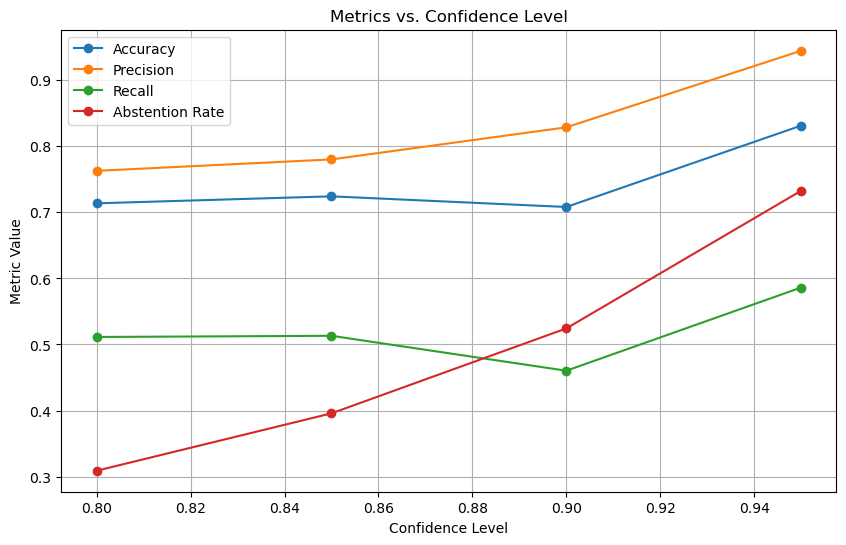

In [53]:
import matplotlib.pyplot as plt

confidence_levels = [0.8, 0.85, 0.9, 0.95]
accuracy_list, precision_list, recall_list, abstention_list = [], [], [], []

for confidence in confidence_levels:
    quantile = np.quantile(nonconformity_scores, confidence)
    prediction_sets = [
        [cls for cls, prob in enumerate(probs) if prob >= 1 - quantile]
        for probs in probs_test
    ]
    confident_indices = [i for i, pred_set in enumerate(prediction_sets) if len(pred_set) == 1]
    confident_preds = [pred_set[0] for i, pred_set in enumerate(prediction_sets) if len(pred_set) == 1]
    confident_y_test = [y_test.tolist()[i] for i in confident_indices]

    accuracy_list.append(accuracy_score(confident_y_test, confident_preds))
    precision_list.append(precision_score(confident_y_test, confident_preds))
    recall_list.append(recall_score(confident_y_test, confident_preds))
    abstention_list.append(1 - len(confident_preds) / len(y_test))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, accuracy_list, label="Accuracy", marker='o')
plt.plot(confidence_levels, precision_list, label="Precision", marker='o')
plt.plot(confidence_levels, recall_list, label="Recall", marker='o')
plt.plot(confidence_levels, abstention_list, label="Abstention Rate", marker='o')
plt.xlabel("Confidence Level")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Confidence Level")
plt.legend()
plt.grid()
plt.show()


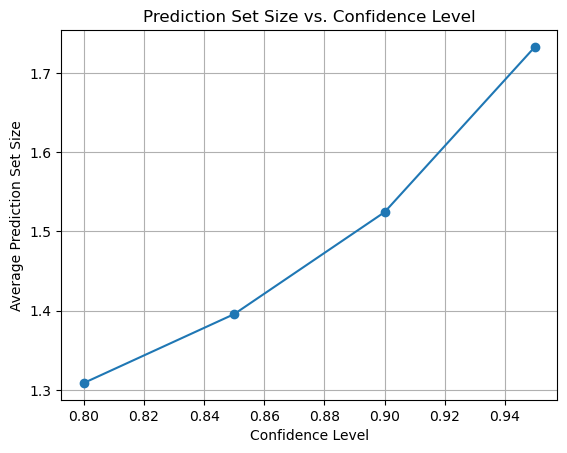

In [43]:
import matplotlib.pyplot as plt

confidence_levels = [0.8, 0.85, 0.9, 0.95]
avg_set_sizes = []

for confidence in confidence_levels:
    quantile = np.quantile(nonconformity_scores, confidence)
    avg_set_size = np.mean([len([cls for cls, prob in enumerate(probs) if prob >= 1 - quantile]) for probs in probs_test])
    avg_set_sizes.append(avg_set_size)

plt.plot(confidence_levels, avg_set_sizes, marker='o')
plt.xlabel("Confidence Level")
plt.ylabel("Average Prediction Set Size")
plt.title("Prediction Set Size vs. Confidence Level")
plt.grid()
plt.show()


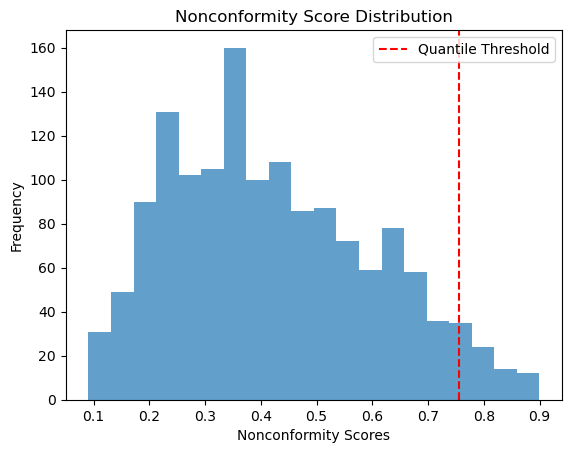

In [44]:
plt.hist(nonconformity_scores, bins=20, alpha=0.7)
plt.axvline(quantile, color='red', linestyle='dashed', label='Quantile Threshold')
plt.xlabel("Nonconformity Scores")
plt.ylabel("Frequency")
plt.title("Nonconformity Score Distribution")
plt.legend()
plt.show()


In [16]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestClassifier


class WCRF:
    def __init__(self, n_trees=100, s=2, gamma=1, labda=1, tree_max_depth=None, combination=1, data_name=None, random_state=None):
        # build a random forest using sklearn RandomForestClassifier
        self.n_trees = n_trees
        self.s = s
        self.labda = labda
        self.gamma = gamma
        self.combination = combination
        self.data_name = data_name
        self.w = np.ones(n_trees)/n_trees
        self.model = RandomForestClassifier(n_estimators=n_trees, max_depth=tree_max_depth, random_state=random_state)
        
        
    def fit(self, X, y):
        # fit the model with training set
        self.model.fit(X,y)
        self.classes = self.model.classes_
        self.n_classes = len(self.classes)
        #################################################################################################
        #################################################################################################

        
        # calculate number of sample in each leave for every tree
        trees = self.model.estimators_
        self.leaves_sample_count = []
        for tree in trees:
            leaves_dict = {}
            n_nodes = tree.tree_.node_count
            children_left = tree.tree_.children_left
            children_right = tree.tree_.children_right
            value = tree.tree_.value.reshape((-1, self.n_classes))
            for i in range(n_nodes):
                is_leaf = (children_left[i] == children_right[i])
                if is_leaf:
                    leaves_dict[i] = value[i]
                    
            self.leaves_sample_count.append(leaves_dict)
        
        # get regions
        regions = self.model.apply(X)
#         regions = list(set(tuple(region) for region in regions))
        
        # create sample number counter dictionary for each region
        self.regions_sample_count = dict()
        sample_count_array = np.zeros((len(regions), self.n_trees,self.n_classes))
        
        # initialize sample counter for each region, the key is a region presented by tuple, the value is a ndarray
        for i in range(len(regions)):
            region = tuple(regions[i])
            self.regions_sample_count[region] = np.zeros((self.n_trees, self.n_classes))   
            
        # build sample counter for each region
            for t in range(self.n_trees):
                self.regions_sample_count[region][t] = self.leaves_sample_count[t][region[t]]
                sample_count_array[i][t] = self.leaves_sample_count[t][region[t]]

        self.regions_pred_info = dict()
## self.leaves_sample_count for each tree... for each leaf node in each tree... class counts per leaf node
## self.regions_sample_count for each region, class distribution of each leaf node in the region...
        return 
        

    def fit_w(self, X, y):
        alpha = 10
        beta = 2
        p_intervals = []
        # get falling leaves for each sample in every tree, return array (n_sample * number_trees)
        valid_regions = self.model.apply(X)
        
        for i in range(len(valid_regions)):
            region=tuple(valid_regions[i])
            if region not in self.regions_pred_info.keys():
                self.regions_sample_count[region] = np.zeros((self.n_trees, self.n_classes))
                for t in range(self.n_trees):
                    self.regions_sample_count[region][t] = self.leaves_sample_count[t][region[t]]
                self.regions_pred_info[region] = self.treat_region(region)
            pred_info = self.regions_pred_info[region]
            p_intervals.append(pred_info[3])
            
        p_intervals = np.array(p_intervals)
        p_infs = p_intervals[:,:,0]
        p_sups = p_intervals[:,:,1]

        if self.combination==1:
            k_under = (p_infs>=0.5)+0
            k_over = (p_sups>0.5)+0
        if self.combination==2:
            k_under = p_infs
            k_over = p_sups
        
        def cost_func(w, labda=self.labda, gamma=self.gamma):
            bels = (k_under*w).sum(axis=1)
            pls = (k_over*w).sum(axis=1)
            u_under = expit(alpha*(bels- 0.5))
            u_over = expit(alpha*(pls - 0.5))
            u = expit(beta*(bels - 0.5)*(pls - 0.5))

            cost = -sum(y*np.log(u_under+0.0001) + (1-y)*np.log(1-u_over+0.0001) + gamma*np.log(1-u+0.0001))/len(y) + 0.5*labda*sum(w**2)

            return cost


        def jac(w,labda=self.labda, gamma=self.gamma):
            bels = (k_under*w).sum(axis=1)
            pls = (k_over*w).sum(axis=1)
            u_under = expit(alpha*(bels- 0.5))
            u_over = expit(alpha*(pls - 0.5))
            u = expit(beta*(bels - 0.5)*(pls - 0.5))
            
            der_1 = -alpha*(y*(1-u_under))@k_under
            der_2 = alpha*((1-y)*u_over)@k_over
            der_3 = beta*(k_under.T@(u.reshape((len(y),1))*k_over) + k_over.T@(u.reshape((len(y),1))*k_under))@w - 0.5*u@(k_under+k_over)

            der_j = (der_1 + der_2 + gamma*der_3)/len(y) + labda*w
            
            return der_j
        
        cons = [{'type': 'eq', 'fun':lambda w: sum(w)-1}]

        bounds = [(0,1)] * self.n_trees
        
        w0 = np.random.rand(self.n_trees)
        res = minimize(cost_func, w0, method='SLSQP',jac=jac, constraints=cons, bounds=bounds)
        print("hello")
        self.w = res.x
        return
        
        
    def treat_region(self, region):
        sample_count = self.regions_sample_count[region]
        sample_count[:,0] = sample_count[:,0] + sample_count[:,1]
        
        p_intervals = np.zeros_like(sample_count)
        
        p_intervals[:,0] = sample_count[:,1]/(sample_count[:,0] + self.s)
        p_intervals[:,1] = (sample_count[:,1] + self.s)/(sample_count[:,0] + self.s)

        
        # predict
        if self.combination==1:
            k_under = (p_intervals[:,0]>=0.5)+0
            k_over = (p_intervals[:,1]>0.5)+0
            bel = round(sum(k_under*self.w),4)
            pl = round(sum(k_over*self.w),4)
            
        if self.combination==2:
            bel = round(sum(p_intervals[:,0]*self.w),4)
            pl = round(sum(p_intervals[:,1]*self.w),4)
        
        if bel >= 0.5:
            prediction = self.classes[1]
        elif pl <= 0.5:
            prediction = self.classes[0]
        else:
            prediction = -1

        return (prediction, bel, pl, p_intervals, sample_count)

        
    def predict(self, X, plot=False):
        count = 0
        # intitialize prediciton list
        predictions = np.zeros(len(X))
        pred_intervals = []
        p_intervals = []
        # get falling leaves for each sample in every tree, return array (n_sample * number_trees)
        test_regions = self.model.apply(X)
        
        for i in range(len(test_regions)):
            region=tuple(test_regions[i])
            if region not in self.regions_pred_info.keys() or True:
                self.regions_sample_count[region] = np.zeros((self.n_trees, self.n_classes))
                for j in range(self.n_trees):
                    self.regions_sample_count[region][j] = self.leaves_sample_count[j][region[j]]
                self.regions_pred_info[region] = self.treat_region(region)
#                 pred_info = self.treat_region(region)
                count += 1
            pred_info = self.regions_pred_info[region]
            
            #print('bel=',pred_info[1],'pl=',pred_info[2],'pre=',pred_info[0])
            predictions[i] = pred_info[0]
            pred_intervals.append([pred_info[1], pred_info[2]])
            p_intervals.append(pred_info[3])
            
        return predictions, pred_intervals, p_intervals
    
    
    def evaluate(self, X_test, y_test,  plot=False, show_confusion_matrix=False):
        # get both imprecise and precise predictions 
        imprecise_predictions ,pred_intervals, p_intervals = self.predict(X_test, y_test)
        precise_predictions = np.zeros(len(y_test))
        if self.combination==2:
            precise_predictions = self.model.predict(X_test)
        else:
            for tree in self.model.estimators_:
                precise_predictions += tree.predict(X_test)
            precise_predictions /= self.n_trees
            precise_predictions[precise_predictions>=0.5] = self.classes[1]
            precise_predictions[precise_predictions<0.5] = self.classes[0]
        
        indeterminate_instance = (imprecise_predictions == -1)
        determinate_instance = (imprecise_predictions != -1)
        
        # calculate single-set length
        single_set_length = len(y_test) - sum(indeterminate_instance)
        
        # calculate determinacy
        determinacy = single_set_length/len(y_test)
        determinacy = round(determinacy*100, 2)
        
        # calculate single-set accuracy
        single_set_accuracy = sum(y_test[determinate_instance]==imprecise_predictions[determinate_instance])/single_set_length
        single_set_accuracy = round(single_set_accuracy*100, 2)
        
        # claculate u65
        u65_score = round(65 + (single_set_accuracy - 65)*determinacy/100, 2)
        
        # claculate precise accuracy
        precise_accuracy = sum(y_test==precise_predictions)/len(y_test)
        precise_accuracy = round(precise_accuracy*100, 2)
        
        # show confusion matrix
        if show_confusion_matrix:
            print('imprecise confusion matrix')
            cm1=metrics.confusion_matrix(y_test, imprecise_predictions)
            cm_display1=metrics.ConfusionMatrixDisplay(confusion_matrix=cm1,
                                          display_labels = [0, 1])
            cm_display1.plot()
        
            print('precise confusion matrix')
            cm2=metrics.confusion_matrix(y_test, precise_predictions)
            cm_display2=metrics.ConfusionMatrixDisplay(confusion_matrix=cm2,
                                          display_labels = [0, 1])
            cm_display2.plot()
        # return result
        return {'u65_score':u65_score, 
                'single_set_accuracy':single_set_accuracy, 
                'determinacy':determinacy, 
                'precise_accuracy':precise_accuracy}, pred_intervals, p_intervals

In [25]:
rf_dataset.columns
X_train, X_test, y_train, y_test = train_test_split(rf_dataset, labels, test_size=0.2, random_state=42)
len(X_train)
len(y_train)

5748

In [27]:
wcrf = WCRF(s=1, gamma=9, labda=2)

In [28]:
wcrf.fit(X_train, y_train)
wcrf.fit_w(X_train, y_train)
wcrf.w

hello


array([1.98363673e-02, 1.21969951e-02, 4.09260899e-03, 3.01342816e-03,
       1.14998651e-17, 1.60217151e-02, 3.66682870e-02, 8.21403810e-03,
       1.38094576e-03, 1.68876689e-02, 2.01444519e-02, 7.98423019e-03,
       4.15836600e-03, 1.36343533e-02, 2.44280754e-02, 7.09589597e-03,
       1.50903826e-02, 1.91153082e-02, 1.71892370e-02, 7.34500606e-03,
       4.27868493e-03, 2.54359100e-03, 9.78391924e-03, 9.65679909e-03,
       2.56191337e-02, 1.33059726e-02, 1.61720212e-03, 3.07673146e-03,
       1.26774893e-02, 1.81355277e-02, 7.05527428e-03, 2.44519143e-02,
       1.19768428e-17, 3.70069134e-18, 1.12045777e-02, 2.11293933e-02,
       1.37876624e-02, 2.97258296e-03, 7.24410043e-03, 3.09478507e-03,
       2.38910580e-02, 9.82994578e-03, 3.72601042e-18, 9.48569764e-03,
       1.89311038e-19, 1.34427504e-02, 2.41006622e-03, 7.21645243e-03,
       7.82505547e-03, 1.59583357e-02, 1.09676609e-17, 1.44429368e-02,
       1.32744591e-02, 2.09802054e-02, 2.35076165e-02, 1.55670170e-02,
      

In [31]:
wcrf.n_classes

2

imprecise confusion matrix


/Users/tylerskowtyler/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/tylerskowtyler/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/tylerskowtyler/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/tylerskowtyler/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/tylerskowtyler/opt/miniconda3/envs/dataviz/lib/python3.10/site-packages/sklearn/utils/validation.

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

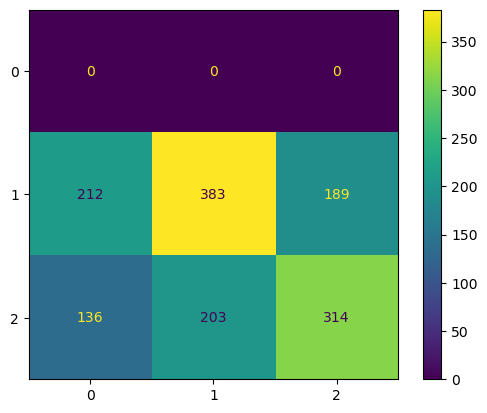

In [32]:
evals=wcrf.evaluate(X_test,y_test,show_confusion_matrix=True)